# Step #1 Setup Cosmos Vector DB and OpenAI Service

In [46]:
# preview version - work in progress

from azure.identity import AzureCliCredential
from azure.keyvault.secrets import SecretClient
import openai
import logging
import tiktoken
import pandas as pd
import pymongo
from dotenv import load_dotenv
load_dotenv()
import PyPDF2
import re

# Set up the Azure Key Vault client and retrieve the Blob Storage account credentials
keyvault_name = 'ffkeyvault731'
azure_openai_resouce_name = 'openai713'
DB_NAME = "customgpt"
COLLECTION_NAME = 'pdfcontent'

client = SecretClient(f"https://{keyvault_name}.vault.azure.net/", AzureCliCredential())
print('keyvault service ready')

# AzureOpenAI Service
def setup_azureopenai():
    openai.api_key = client.get_secret('openai-api-key').value
    openai.api_type = "azure"
    openai.api_base = f'https://{azure_openai_resouce_name}.openai.azure.com'
    openai.api_version = '2023-05-15'
    print('azure openai service ready')

# public openai service
def setup_public_openai():
    openai.api_key = client.get_secret('openai-api-key-public').value
    print('public openai service ready')


def setup_cosmos_connection():
    COSMOS_CLUSTER_CONNECTION_STRING = client.get_secret('cosmos-cluster-string').value
    cosmosclient = pymongo.MongoClient(COSMOS_CLUSTER_CONNECTION_STRING)

    db = cosmosclient[DB_NAME]
    collection = cosmosclient[DB_NAME][COLLECTION_NAME]

    # Send a ping to confirm a successful connection
    try:
        cosmosclient.admin.command('ping')
        print("Pinged your deployment. You successfully connected to MongoDB!")
        print("You are using the database:", db)
        print("You are using the collection:", collection)

    except Exception as e:
        print(e)
    return collection, db

setup_public_openai()
collection, db = setup_cosmos_connection()

keyvault service ready
public openai service ready
Pinged your deployment. You successfully connected to MongoDB!
You are using the database: Database(MongoClient(host=['c.hexacluster.mongocluster.cosmos.azure.com:10260'], document_class=dict, tz_aware=False, connect=True, tls=True, authmechanism='SCRAM-SHA-256', retrywrites=False, maxidletimems=120000), 'customgpt')
You are using the collection: Collection(Database(MongoClient(host=['c.hexacluster.mongocluster.cosmos.azure.com:10260'], document_class=dict, tz_aware=False, connect=True, tls=True, authmechanism='SCRAM-SHA-256', retrywrites=False, maxidletimems=120000), 'customgpt'), 'pdfcontent')


# Step #2 Functions for Populating the Vector DB

In [41]:
# prepare content for insertion into cosmos db
def prepare_content(text_content):
  embeddings = create_embeddings_with_openai(text_content)
  request = [
    {
    "textContent": text_content, 
    "vectorContent": embeddings}
  ]
  return request


# create embeddings
def create_embeddings_with_openai(input):
    #print('Generating response from OpenAI...')

    ###### uncomment for AzureOpenAI model usage and comment code below
    # embeddings = openai.Embedding.create( 
    #     engine='<name of the embedding deployment >', 
    #     input=input)["data"][0]["embedding"]

    ###### public openai model usage and comment code above
    embeddings = openai.Embedding.create(
        model='text-embedding-ada-002', 
        input=input)["data"][0]["embedding"]
    
    # Number of embeddings    
    # print(len(embeddings))

    return embeddings


# insert the requests
def insert_requests(text_input):
    request = prepare_content(text_input)
    return collection.insert_many(request).inserted_ids


# Creates a searchable index for the vector content
def create_index():
  
  # delete and recreate the index. This might only be necessary once.
  collection.drop_indexes()

  embedding_len = 1536
  print(f'creating index with embedding length: {embedding_len}')
  db.command({
    'createIndexes': COLLECTION_NAME,
    'indexes': [
      {
        'name': 'vectorSearchIndex',
        'key': {
          "vectorContent": "cosmosSearch"
        },
        'cosmosSearchOptions': {
          'kind': 'vector-ivf',
          'numLists': 100,
          'similarity': 'COS',
          'dimensions': embedding_len
        }
      }
    ]
  })

# Resets the DB and deletes all values from the collection to avoid dublicates
#collection.delete_many({})

# Step #3 - Document Cracking, Creating Embeddings and Insert into Cosmos DB

In [42]:
# document cracking function to insert data from the excel sheet

def split_text_into_paragraphs(text):
    paragraphs = re.split(r'\n{2,}', text)
    return paragraphs

def slice_pdf_into_records(pdf_path, max_sentences):
    records = []
    
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        
        for page in reader.pages:
            text = page.extract_text()
            paragraphs = split_text_into_paragraphs(text)
            
            current_record = ''
            sentence_count = 0
            
            for paragraph in paragraphs:
                sentences = re.split(r'(?<=[.!?])\s+', paragraph)
                
                for sentence in sentences:
                    current_record += sentence
                    
                    sentence_count += 1
                    
                    if sentence_count >= max_sentences:
                        records.append(current_record)
                        current_record = ''
                        sentence_count = 0
                
                if sentence_count < max_sentences:
                    current_record += ' '  # Add space between paragraphs
            
            # If there is remaining text after the loop, add it as a record
            if current_record:
                records.append(current_record)
    
    return records

# get file from root/data folder
pdf_path = '../data/vector_db_data/zurich_tax_info_2023.pdf'

max_sentences = 20  # Adjust the slice size as per your requirement

result = slice_pdf_into_records(pdf_path, max_sentences)

# print the length of result
print(f'{len(result)} vectors created with maximum {max_sentences} sentences each.')

# Print the sliced records
for i, record in enumerate(result):
    insert_requests(record)
    if i < 5:
        print(record[0:100])
        print('-------------------')

create_index()

print(f'number of records in the vector DB: {collection.count_documents({})}')

99 vectors created with maximum 20 sentences each.
Kanton Zürich
Steueramt
Wegleitung zur 
Steuererklärung2022
Reichen Sie Ihre Steuererklärung online 
-------------------
A
Abonnementskosten (ZVV etc.)  15
AHV (Beiträge an die AHV)  18
AHV-Renten  11
Aktien  29
Alimente 
-------------------
3Kanton Zürich
Steueramt
Wegleitung zur  
Steuererklärung2022
Reichen Sie Ihre Steuererklärung onlin
-------------------
4Wer hat im Kalenderjahr 2023 
eine Steuererklärung 2022 
 einzureichen?Eine Steuererklärung 2022 ha
-------------------
Die Steuererklärungspflicht im Kanton Zürich ist durch Einreichung der vollständig ausgefüllten 
und
-------------------
creating index with embedding length: 1536
278


In [ ]:
# display all documents in the collection
for doc in collection.find({}):
    print(doc.get('_id'), doc.get('textContent')[0:40], doc.get('vectorContent')[0:5])

# Step #4 Vector Search and Question Answering with OpenAI GPT-3.5 Turbo

In [47]:
# Cosmos DB Vector Search API Command
def vector_search(vector_query, max_number_of_results=2):
  results = collection.aggregate([
    {
      '$search': {
        "cosmosSearch": {
          "vector": vector_query,
          "path": "vectorContent",
          "k": max_number_of_results
        },
      "returnStoredSource": True
      }
    }
  ])
  return results


# openAI request - ChatGPT 3.5 Turbo Model
def openai_request(prompt, model_engine='gpt-3.5-turbo'):
    completion = openai.ChatCompletion.create(model=model_engine, messages=prompt, temperature=0.2, max_tokens=500)
    return completion.choices[0].message.content


# define OpenAI Prompt for News Tweet
def create_tweet_prompt(user_question, result_json):
    instructions = f'You are an assistant that answers questions based on sources provided. \
    If the information is not in the provided source, you answer with "I don\'t know". '
    task = f"{user_question} Translate the response to english /n \
    source: {result_json}"
    
    prompt = [{"role": "system", "content": instructions }, 
              {"role": "user", "content": task }]

    return prompt

# Step #5 Testing the Custom ChatGPT Solution

In [48]:
# define OpenAI Prompt 
users_question = "When do I have to submit my tax return?"

# generate embeddings for the question
user_question_embeddings = create_embeddings_with_openai(user_question)

# search for the question in the cosmos db
search_results = vector_search(user_question_embeddings, 1)
print(search_results)

# prepare the results for the openai prompt
result_json = []

# print each document in the result
# remove all empty values from the results json
search_results = [x for x in search_results if x]
for doc in search_results:
    display(doc.get('_id'), doc.get('textContent'), doc.get('vectorContent')[0:5])
    result_json.append(doc.get('textContent'))


# create the prompt
prompt = create_tweet_prompt(user_question, result_json)
display(prompt)

# generate the response
response = openai_request(prompt)

display(f'User question: {users_question}')
display(f'OpenAI response: {response}')

ObjectId('6471e32e9f3b7af98400a1e1')

'4Wer hat im Kalenderjahr 2023 \neine\xa0Steuererklärung 2022 \n einzureichen?Eine Steuererklärung 2022 haben im Kalenderjahr 2023 alle natürlichen Personen einzureichen, \ndie am 31.Dezember 2022\n• im Kanton Zürich Wohnsitz hatten oder\n• im Kanton Zürich Liegenschaften oder Betriebsstätten (bzw.Geschäftsbetriebe)  besassen.Zudem haben Steuerpflichtige mit Wohnsitz in einem anderen Kanton auch dann erst im \n Kalenderjahr 2023 eine Steuererklärung 2022 einzureichen, wenn sie im Laufe des Kalender -\njahres 2022 ihre Steuerpflicht im Kanton Zürich durch Aufgabe einer Liegenschaft oder Be -\ntriebsstätte beendet haben.Die Stellung der Partnerinnen oder Partner bei eingetragenen Partnerschaften entspricht seit \ndem 1.Januar 2007 derjenigen von Ehegatten.Ausführungen unter dem Titel «Ehegatten» \ngelten auch für Partnerinnen oder Partner.Beim Ausfüllen der Steuererklärung sind die Anga-\nben derjenigen Person, deren Nachname alphabetisch an erster Stelle kommt, unter dem Titel \n«Person

[0.0041758399456739426,
 -0.011536800302565098,
 0.013691077008843422,
 -0.027678443118929863,
 -0.0051819924265146255]

[{'role': 'system',
  'content': 'You are an assistant that answers questions based on sources provided.     If the information is not in the provided source, you answer with "I don\'t know". '},
 {'role': 'user',
  'content': "Wann muss ich meine Steuererklärung einreichen? Translate the response to english /n     source: ['4Wer hat im Kalenderjahr 2023 \\neine\\xa0Steuererklärung 2022 \\n einzureichen?Eine Steuererklärung 2022 haben im Kalenderjahr 2023 alle natürlichen Personen einzureichen, \\ndie am 31.Dezember 2022\\n• im Kanton Zürich Wohnsitz hatten oder\\n• im Kanton Zürich Liegenschaften oder Betriebsstätten (bzw.Geschäftsbetriebe)  besassen.Zudem haben Steuerpflichtige mit Wohnsitz in einem anderen Kanton auch dann erst im \\n Kalenderjahr 2023 eine Steuererklärung 2022 einzureichen, wenn sie im Laufe des Kalender -\\njahres 2022 ihre Steuerpflicht im Kanton Zürich durch Aufgabe einer Liegenschaft oder Be -\\ntriebsstätte beendet haben.Die Stellung der Partnerinnen oder Part

'User question: When do I have to submit my tax return?'

'OpenAI response: When do I have to submit my tax return? \n\nAll natural persons who had their residence in the canton of Zurich on December 31, 2022, or who owned properties or business premises (or business operations) in the canton of Zurich, must submit a tax return for 2022 in the calendar year 2023. Taxpayers with a residence in another canton also have to submit a tax return for 2022 in the calendar year 2023 if they ended their tax liability in the canton of Zurich by giving up a property or business premises during the calendar year 2022. If you turned 18 in the tax period 2022 (persons born in 2004), you must submit your own tax return (for the tax period 2022) for the first time in the calendar year 2023.'

# Step #6 Visualizing the Embeddings 

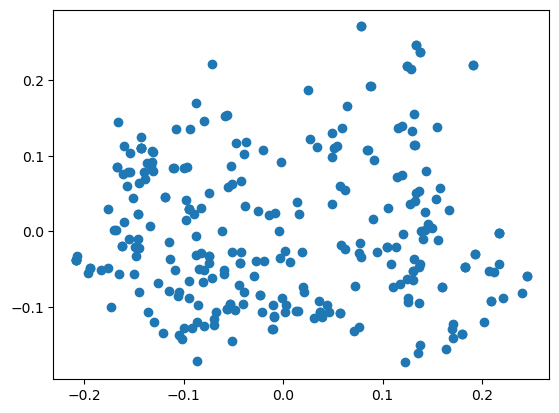

In [52]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# get all the embeddings from the vector db
all_embeddings = []
for doc in collection.find({}):
    all_embeddings.append(doc.get('vectorContent'))

# reduce the dimensionality of the vectors to two dimensions
pca = PCA(n_components=2)
pca.fit(all_embeddings)
reduced_embeddings = pca.transform(all_embeddings)

# plot the reduced embeddings
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1])
plt.show()
